# Peptide Detectability (Training and fine tuning) 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook provides a concise walkthrough of the process for reading a dataset, training, and fine-tuning a model for peptide detectability prediction. 

The dataset used in this example is derived from:

- **ProteomTools Dataset**: Includes data from the PRIDE repository with the following identifiers: `PXD004732`, `PXD010595`, and `PXD021013`.
- **MAssIVE Dataset**: Deposited in the ProteomeXchange Consortium via the MAssIVE partner repository with the identifier `PXD024364`.

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

#### Installing the DLOmix Package

If you have not installed the DLOmix package yet, you need to do so before running the code. 

You can install the DLOmix package using pip.

In [1]:
# # # install the DLOmix package in the current environment using pip

# !python -m pip install git+https://github.com/wilhelm-lab/dlomix.git@feature/detectability-integration-hf-updates

#### Importing Required Libraries

Before running the code, ensure you import all the necessary libraries. These imports are essential for accessing the functionalities needed for data processing, model training, and evaluation.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import dlomix
import sys
import os
print([x for x in dir(dlomix) if not x.startswith("_")])

['META_DATA']


In [3]:
dlomix.__version__

'0.1.3dev'

## 1. Load Data for Training

You can import the `DetectabilityDataset` class and create an instance to manage data for training, validation, and testing. This instance handles TensorFlow dataset objects and simplifies configuring and controlling how your data is split.

#### Parameters

- **data_source** (`Optional[Union[str, List]]`): The path or list of paths to the data source file(s). Defaults to `None`.
  
- **val_data_source** (`Optional[Union[str, List]]`): The path or list of paths to the validation data source file(s). Defaults to `None`.

- **test_data_source** (`Optional[Union[str, List]]`): The path or list of paths to the test data source file(s). Defaults to `None`.

- **data_format** (`str`): The format of the data source file(s). Defaults to `"parquet"`.

- **sequence_column** (`str`): The name of the column containing the peptide sequences. Defaults to `"Sequences"`.

- **label_column** (`str`): The name of the column containing the class labels. Defaults to `"Classes"`.

- **val_ratio** (`float`): The ratio of validation data to split from the training data. Defaults to `0.2`.

- **max_seq_len** (`Union[int, str]`): The maximum length of the peptide sequences. Defaults to `30`.

- **dataset_type** (`str`): The type of dataset to use. Defaults to `"tf"`.

- **batch_size** (`int`): The batch size for training and evaluation. Defaults to `256`.

- **model_features** (`Optional[List[str]]`): The list of features to use for the model. Defaults to `None`.

- **dataset_columns_to_keep** (`Optional[List[str]]`): The list of columns to keep in the dataset. Defaults to `["Proteins"]`.

- **features_to_extract** (`Optional[List[Union[Callable, str]]]`): The list of features to extract from the dataset. Defaults to `None`.

- **pad** (`bool`): Whether to pad the sequences to the maximum length. Defaults to `True`.

- **padding_value** (`int`): The value to use for padding. Defaults to `0`.

- **alphabet** (`Dict`): The mapping of characters to integers for encoding the sequences. Defaults to `ALPHABET_UNMOD`.

- **with_termini** (`bool`): Whether to add the N- and C-termini in the sequence column, even if they do not exist. Defaults to `True`.

- **encoding_scheme** (`Union[str, EncodingScheme]`): The encoding scheme to use for encoding the sequences. Defaults to `EncodingScheme.UNMOD`.

- **processed** (`bool`): Whether the data has been preprocessed. Defaults to `False`.

- **enable_tf_dataset_cache** (`bool`): Flag to indicate whether to enable TensorFlow Dataset caching (call `.cache()` on the generated TF Datasets). Defaults to `False`.

- **disable_cache** (`bool`): Whether to disable Hugging Face datasets caching. Defaults to `False`.


**Note**: If class labels are provided, the following encoding scheme should be used:
- **Non-Flyer**: 0
- **Weak Flyer**: 1
- **Intermediate Flyer**: 2
- **Strong Flyer**: 3

In [4]:
from dlomix.data import DetectabilityDataset


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [5]:
from dlomix.constants import CLASSES_LABELS, alphabet, aa_to_int_dict

In [6]:
CLASSES_LABELS, len(alphabet), aa_to_int_dict

(['Non-Flyer', 'Weak Flyer', 'Intermediate Flyer', 'Strong Flyer'],
 21,
 {'0': 0,
  'A': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'K': 9,
  'L': 10,
  'M': 11,
  'N': 12,
  'P': 13,
  'Q': 14,
  'R': 15,
  'S': 16,
  'T': 17,
  'V': 18,
  'W': 19,
  'Y': 20})

In [7]:
max_pep_length = 40
BATCH_SIZE = 128 
            
# The Class handles all the inner details, we have to provide the column names and the alphabet for encoding
# If the data is already split with a specific logic (which is generally recommended) -> val_data_source and test_data_source are available as well

# Splitting on Proteins is not implemented -> we should have this logic outside of the Dataset class

hf_data = "Wilhelmlab/detectability-proteometools"
detectability_data = DetectabilityDataset(data_source=hf_data,
                                          #val_data_source=VAL_DATAPATH,
                                          #test_data_source=TEST_DATAPATH,
                                          data_format='hub',
                                          max_seq_len=max_pep_length,
                                          label_column="Classes",
                                          sequence_column="Sequences",
                                          dataset_columns_to_keep=None,
                                          batch_size=BATCH_SIZE,
                                          with_termini=False,
                                          alphabet=aa_to_int_dict)

Applying step: SequenceParsingProcessor on split train...


/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:262: UserWarning: The provided data is assumed to be hosted on the Hugging Face Hub since data_format is set to "hub". Validation and test data sources will be ignored.
  warnings.warn(
/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:329: UserWarning: 
                Multiple data sources or a single non-train data source provided {'train': 'HF hub dataset - Wilhelmlab/detectability-proteometools - train', 'val': 'HF hub dataset - Wilhelmlab/detectability-proteometools - val', 'test': 'HF hub dataset - Wilhelmlab/detectability-proteometools - test'}, please ensure that the data sources are already split into train, val and test sets
                since no splitting will happen. If not, please provide only one data_source and set the val_ratio to split the data into train and val sets."
                
  warnings.warn(
/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/da

Mapping SequenceParsingProcessor:   0%|          | 0/236758 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split val...


Mapping SequenceParsingProcessor:   0%|          | 0/59190 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split test...


Mapping SequenceParsingProcessor:   0%|          | 0/32884 [00:00<?, ? examples/s]

Applying step: SequencePTMRemovalProcessor on split train...


Mapping SequencePTMRemovalProcessor:   0%|          | 0/236758 [00:00<?, ? examples/s]

Applying step: SequencePTMRemovalProcessor on split val...


Mapping SequencePTMRemovalProcessor:   0%|          | 0/59190 [00:00<?, ? examples/s]

Applying step: SequencePTMRemovalProcessor on split test...


Mapping SequencePTMRemovalProcessor:   0%|          | 0/32884 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split train...


Mapping SequenceEncodingProcessor:   0%|          | 0/236758 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split val...


Mapping SequenceEncodingProcessor:   0%|          | 0/59190 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split test...


Mapping SequenceEncodingProcessor:   0%|          | 0/32884 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split train...


Mapping SequencePaddingProcessor:   0%|          | 0/236758 [00:00<?, ? examples/s]

Filter:   0%|          | 0/236758 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split val...


Mapping SequencePaddingProcessor:   0%|          | 0/59190 [00:00<?, ? examples/s]

Filter:   0%|          | 0/59190 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split test...


Mapping SequencePaddingProcessor:   0%|          | 0/32884 [00:00<?, ? examples/s]

In [8]:
detectability_data._data_files_available_splits

{'train': 'HF hub dataset - Wilhelmlab/detectability-proteometools - train',
 'val': 'HF hub dataset - Wilhelmlab/detectability-proteometools - val',
 'test': 'HF hub dataset - Wilhelmlab/detectability-proteometools - test'}

In [9]:
detectability_data["train"]["_parsed_sequence"][0]

['T', 'R', 'E', 'G', 'V', 'V', 'Q', 'G', 'V', 'A', 'S', 'V', 'A', 'E', 'K']

In [10]:
pd.read_csv("/Users/Omar/Desktop/Refactored_notebooks_and_data_splits/ProteomeTools/1_ProteomeTools_train_dataset.csv").shape, pd.read_csv("/Users/Omar/Desktop/Refactored_notebooks_and_data_splits/ProteomeTools/2_ProteomeTools_val_dataset.csv").shape, pd.read_csv("/Users/Omar/Desktop/Refactored_notebooks_and_data_splits/ProteomeTools/3_ProteomeTools_test_dataset.csv").shape

((236758, 2), (59190, 2), (32884, 2))

In [11]:
# This is the dataset with train, val, and test splits  
# You can see the column names under each split (the columns starting with _ are internal, but can also be used to look up original sequences for example "_parsed_sequence")
detectability_data

DatasetDict({
    train: Dataset({
        features: ['Sequences', 'Classes', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 236758
    })
    val: Dataset({
        features: ['Sequences', 'Classes', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 59190
    })
    test: Dataset({
        features: ['Sequences', 'Classes', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 32884
    })
})

In [12]:
# Accessing elements in the dataset is done by specificing the split name and then the column name
# Example here for one sequence after encoding & padding comapred to the original sequence

detectability_data["train"]["Sequences"][0], "".join(detectability_data["train"]["_parsed_sequence"][0])

([17,
  15,
  4,
  6,
  18,
  18,
  14,
  6,
  18,
  1,
  16,
  18,
  1,
  4,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'TREGVVQGVASVAEK')

In [13]:
 "Training examples", detectability_data["train"]

('Training examples',
 Dataset({
     features: ['Sequences', 'Classes', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
     num_rows: 236758
 }))

In [14]:
"Validation examples", detectability_data["val"]

('Validation examples',
 Dataset({
     features: ['Sequences', 'Classes', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
     num_rows: 59190
 }))

In [15]:
"Test examples", detectability_data["test"]

('Test examples',
 Dataset({
     features: ['Sequences', 'Classes', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
     num_rows: 32884
 }))

## 2. Model

We can now create the model. The model architecture is an encoder-decoder with an attention mechanism, that is based on Bidirectional Recurrent Neural Network (BRNN) with Gated Recurrent Units (GRU). Both the Encoder and Decoder consists of a single layer, with the Decoder also including a Dense layer. The model has the default working arguments.

In [16]:
from dlomix.models import DetectabilityModel

In [17]:
total_num_classes = len(CLASSES_LABELS)
input_dimension = len(alphabet)
num_cells = 64

model = DetectabilityModel(num_units = num_cells, num_clases = total_num_classes)

2024-10-28 12:00:33.757071: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-10-28 12:00:33.757096: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-10-28 12:00:33.757103: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-10-28 12:00:33.757133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-28 12:00:33.757145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3. Training and saving the model

You can train the model using the standard Keras approach. The training parameters provided here are those initially configured for the detectability model. However, you have the flexibility to modify these parameters to suit your specific needs.

#### Compile the Model

Compile the model with the selected settings. You can use built-in TensorFlow options or define and pass custom settings for the optimizer, loss function, and metrics. The default configurations match those used in the original study, but you can modify these settings according to your preferences.

Early stopping is also configured with the original settings, but the parameters can be adjusted based on user preferences. Early stopping monitors a performance metric (e.g., validation loss) and halts training when no improvement is observed for a specified number of epochs. This feature helps prevent overfitting and ensures efficient training.

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            mode = 'min', 
                                            verbose = 1, 
                                            patience = 5)


model_save_path = 'output/weights/new_base_model/base_model_weights_detectability'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                      monitor='val_sparse_categorical_accuracy', # changed to sparse categorical accuracy (no need to one-hot encode the true labels)
                                                      mode='max',
                                                      verbose=1,
                                                      save_best_only=True, 
                                                      save_weights_only=True)

model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy', 
              metrics='sparse_categorical_accuracy') # changed to sparse version to spare one-hot encoding the labels

We save the results of the training process to enable a detailed examination of the metrics and losses at a later stage. We define the number of epochs for training and supply the training and validation data previously generated. This approach allows us to effectively monitor the model’s performance and make any necessary adjustments.

In [19]:
# Access to the tensorflow datasets is done by referencing the tensor_train_data or tensor_val_data
history = model.fit(detectability_data.tensor_train_data,
                    validation_data = detectability_data.tensor_val_data,
                    epochs = 50, 
                    callbacks=[callback, model_checkpoint])

Epoch 1/2


/Users/Omar/miniconda3/envs/dlx/lib/python3.11/site-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
2024-10-28 12:00:36.840957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-10-28 12:00:37.311643: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expecte

1850/1850 [==============================] - ETA: 0s - loss: 0.9729 - sparse_categorical_accuracy: 0.5603
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.60282, saving model to output/weights/new_base_model/base_model_weights_detectability
1850/1850 [==============================] - 530s 284ms/step - loss: 0.9729 - sparse_categorical_accuracy: 0.5603 - val_loss: 0.8791 - val_sparse_categorical_accuracy: 0.6028
Epoch 2/2
1850/1850 [==============================] - ETA: 0s - loss: 0.8669 - sparse_categorical_accuracy: 0.6099
Epoch 2: val_sparse_categorical_accuracy improved from 0.60282 to 0.62056, saving model to output/weights/new_base_model/base_model_weights_detectability
1850/1850 [==============================] - 533s 288ms/step - loss: 0.8669 - sparse_categorical_accuracy: 0.6099 - val_loss: 0.8412 - val_sparse_categorical_accuracy: 0.6206


## 4. Testing and Reporting


We use the test dataset to assess our model's performance, which is only applicable if labels are available. The `DetectabilityReport` class allows us to compute various metrics, generate reports, and create plots for a comprehensive evaluation of the model.

Note: The reporting module is currently under development, so some features may be unstable or subject to change.

In the next cell, set the path to the model weights. By default, it points to the newly trained base model. If using different weights, update the path accordingly.

In [20]:
model_save_path = 'output/weights/new_base_model/base_model_weights_detectability'

In [21]:
## Loading best model's weights 

model.load_weights(model_save_path)

##### Generate Predictions on Test Data Using `model.predict`

To obtain predictions for your test data, use the Keras `model.predict` method. Simply pass your test dataset to this method, and it will return the model's predictions.

In [22]:
predictions = model.predict(detectability_data.tensor_test_data)

257/257 [==============================] - 40s 153ms/step


In [23]:
predictions.shape

(32884, 4)

To generate reports and calculate evaluation metrics against predictions, we obtain the targets and the data for the specific dataset split. This can be achieved using the `DetectabilityDataset` class directly.

In [24]:
# access val dataset and get the Classes column
test_targets = detectability_data["test"]["Classes"]


# if needed, the decoded version of the classes can be retrieved by looking up the class names
test_targets_decoded = [CLASSES_LABELS[x] for x in test_targets]


test_targets[0:5], test_targets_decoded[0:5]

([0, 1, 1, 2, 1],
 ['Non-Flyer', 'Weak Flyer', 'Weak Flyer', 'Intermediate Flyer', 'Weak Flyer'])

In [25]:
# The dataframe needed for the report

test_data_df = pd.DataFrame(
    {
        "Sequences": detectability_data["test"]["_parsed_sequence"], # get the raw parsed sequences
        "Classes": test_targets, # get the test targets from above
#         "Proteins": detectability_data["test"]["Proteins"] # get the Proteins column from the dataset object
    }
)

test_data_df.Sequences = test_data_df.Sequences.apply(lambda x: "".join(x)) # join the sequences since they are a list of string amino acids.
test_data_df.head(5)

,Sequences,Classes
0,TEKDFENGP,0
1,ISLRSEYR,1
2,TGDAISVMSEVAQTLLTQDVR,1
3,VIFGTPR,2
4,SLSGLLHSASGGGASGGWR,1


In [26]:
from dlomix.reports.DetectabilityReport import DetectabilityReport, predictions_report
WANDB_REPORT_API_DISABLE_MESSAGE=True

#### Generate a Report Using the `DetectabilityReport` Class

The `DetectabilityReport` class provides a comprehensive way to evaluate your model by generating detailed reports and visualizations. The outputs include:

1. **A PDF Report**: This includes evaluation metrics and plots.
2. **A CSV File**: Contains the model’s predictions.
3. **Independent Image Files**: Visualizations are saved as separate image files.

To generate a report, provide the following parameters to the `DetectabilityReport` class:

- **targets**: The true labels for the dataset, which are used to assess the model’s performance.
- **predictions**: The model’s output predictions for the dataset, which will be compared against the true labels.
- **input_data_df**: The DataFrame containing the input data used for generating predictions.
- **output_path**: The directory path where the generated reports, images, and CSV file will be saved.
- **history**: The training history object (e.g., containing metrics from training) if available. Set this to `None` if not applicable, such as when the report is generated for predictions without training.
- **rank_by_prot**: A boolean indicating whether to rank peptides based on their associated proteins (`True` or `False`). Defaults to `False`.
- **threshold**: The classification threshold used to adjust the decision boundary for predictions. By default, this is set to `None`, meaning no specific threshold is applied.
- **name_of_dataset**: The name of the dataset used for generating predictions, which will be included in the report to provide context.
- **name_of_model**: The name of the model used to generate the predictions, which will be specified in the report for reference.

Note: The reporting module is currently under development, so some features may be unstable or subject to change.

In [27]:
# Since the detectabiliy report expects the true labels in one-hot encoded format, we expand them here. Otherwise, the reporting class can be updated.

num_classes = np.max(test_targets) + 1
test_targets_one_hot = np.eye(num_classes)[test_targets] # THIS CAN BE CHANGED 
test_targets_one_hot.shape, len(test_targets)

((32884, 4), 32884)

In [28]:
report = DetectabilityReport(targets = test_targets_one_hot, 
                             predictions = predictions, 
                             input_data_df = test_data_df,
                             output_path = "./output/report_on_ProteomeTools", 
                             history = history, 
                             rank_by_prot = False,
                             threshold = None,
                             name_of_dataset = 'ProteomeTools',
                             name_of_model = 'Base model (new)')

Binary Accuracy: 0.93

Categorical Accuracy: 0.62

Matthews Correlation Coefficient (MCC): 0.81

True Positive Rate (Recall): 0.95

False Positive Rate (Specificity): 0.86

Precision: 0.95

F1 Score: 0.95


#### Predictions report

In [29]:
results_df = report.detectability_report_table
results_df.head(5)

,Sequences,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions,Rank
0,SYLYFEEK,0.010,0.058,0.932,0.001,1.000,Strong Flyer,Strong Flyer,Flyer,Flyer,1
1,EYLQSLSYK,0.020,0.109,0.871,0.001,1.000,Strong Flyer,Strong Flyer,Flyer,Flyer,2
2,DYVIDLEK,0.009,0.057,0.933,0.002,0.999,Strong Flyer,Strong Flyer,Flyer,Flyer,3
3,SYVDLLVK,0.013,0.067,0.919,0.002,0.999,Intermediate Flyer,Strong Flyer,Flyer,Flyer,4
4,VYTQVEFK,0.012,0.074,0.913,0.001,0.999,Strong Flyer,Strong Flyer,Flyer,Flyer,5


#### Generating Evaluation Plots with `DetectabilityReport`

The `DetectabilityReport` class enables you to generate a range of plots to visualize and evaluate model performance. It offers a comprehensive suite of visualizations to help you interpret the results of your model's predictions. Here’s how to use it:

##### Training and Validation Metrics

These plots show the training and validation metrics over epochs. The first plot displays the loss, and the second shows the categorical accuracy. Both plots are generated from the `history` object recorded during the model training process.

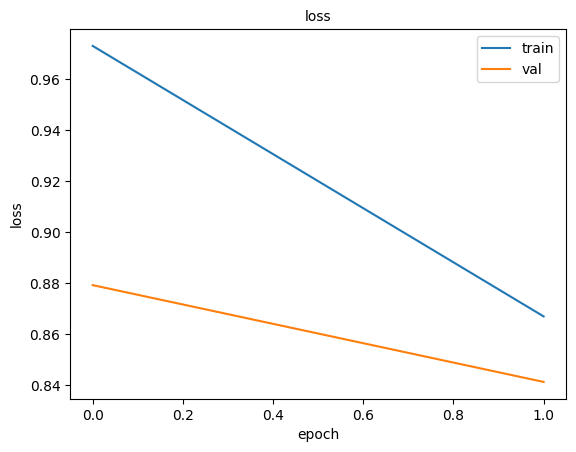

In [30]:
report.plot_keras_metric("loss")

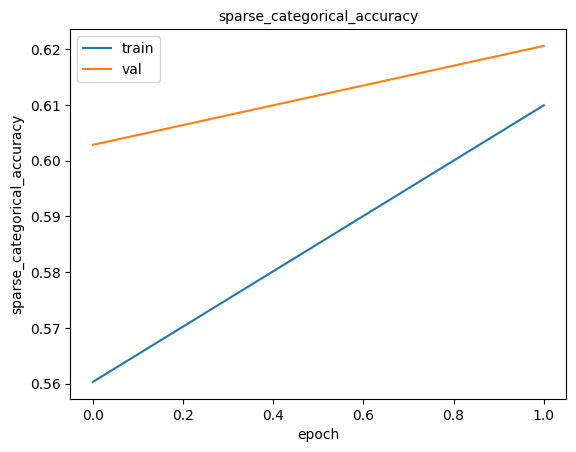

In [31]:
report.plot_keras_metric("sparse_categorical_accuracy")

##### ROC curve (Binary)

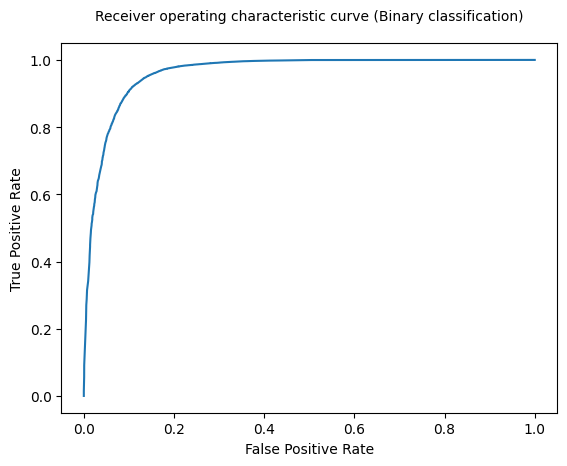

In [32]:
report.plot_roc_curve_binary()

##### Confusion matrix (Binary)

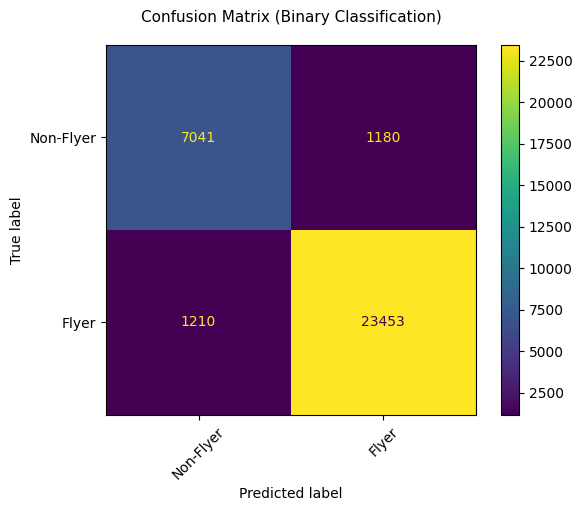

In [33]:
report.plot_confusion_matrix_binary()

##### ROC curve (Multi-class)

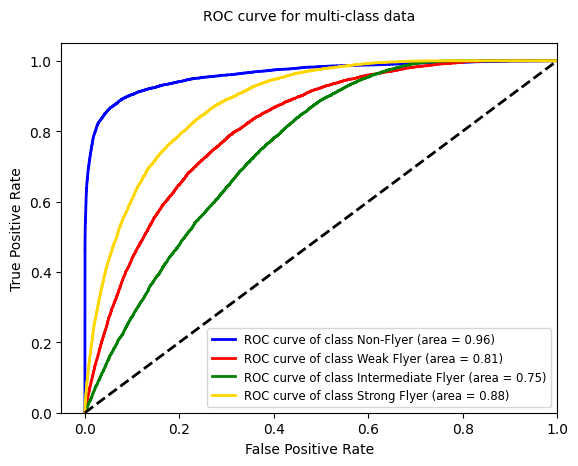

In [34]:
report.plot_roc_curve()

##### Confusion matrix (Multi-class)

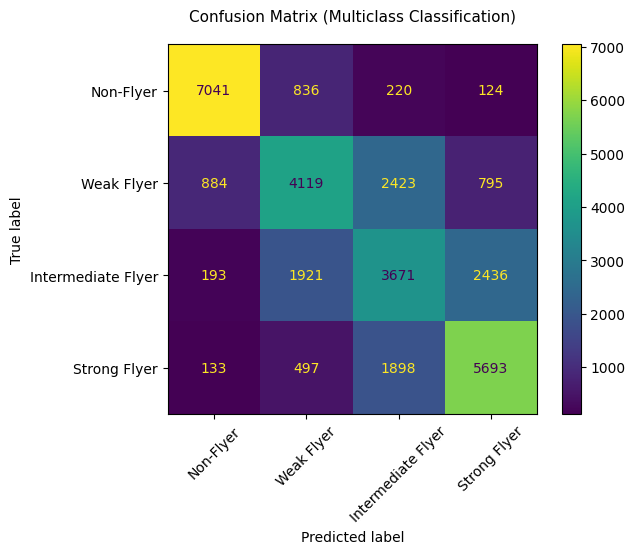

In [35]:
report.plot_confusion_matrix_multiclass()

#### Heatmap of Average Error Between Actual and Predicted Classes

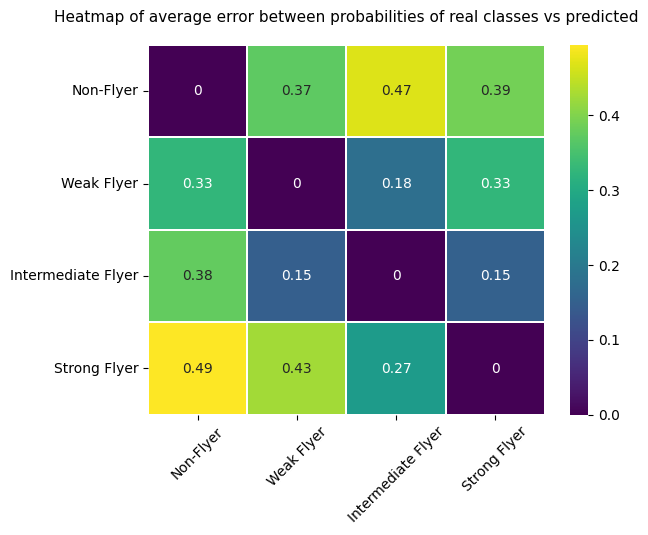

In [36]:
report.plot_heatmap_prediction_prob_error()

We can also produce a complete report with all the relevant plots in one PDF file by calling the `generate_report` function.

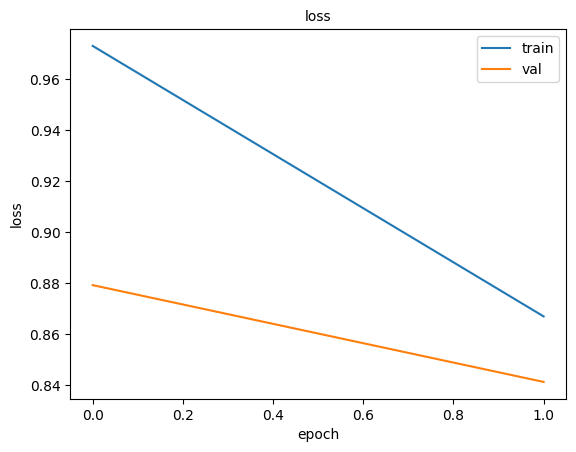

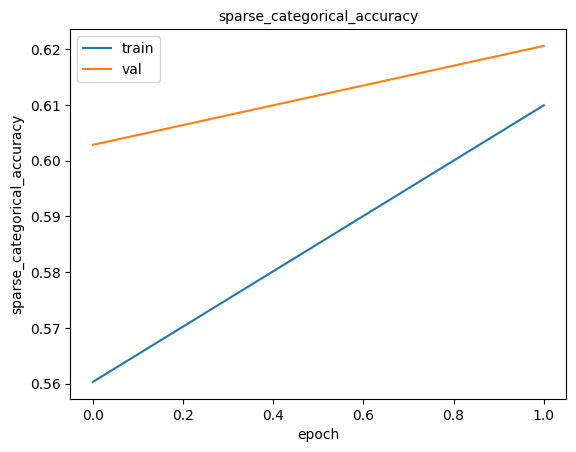

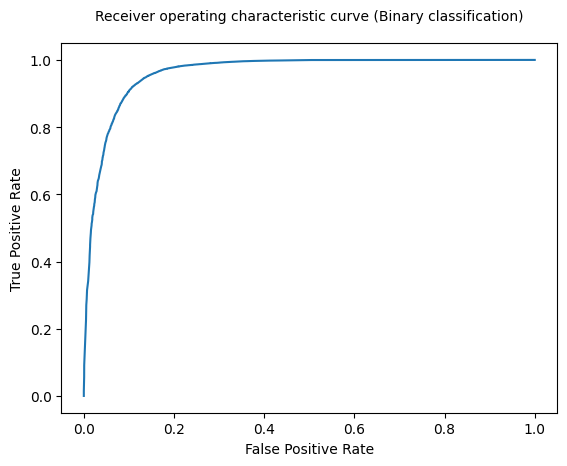

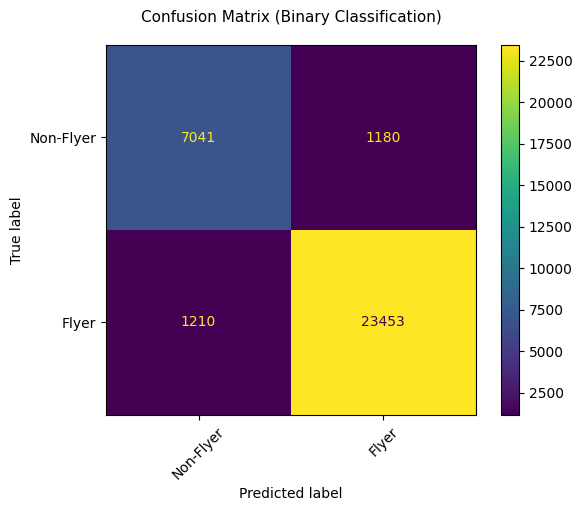

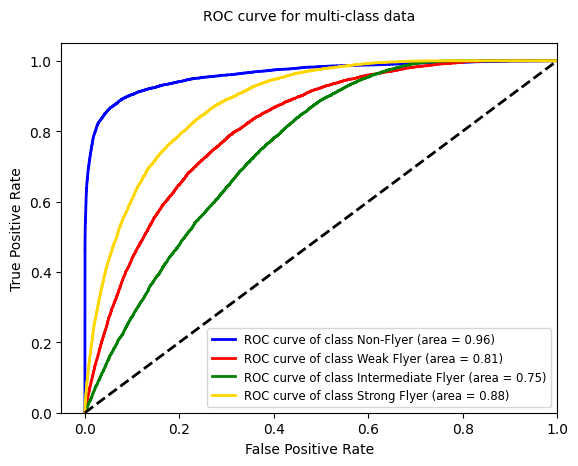

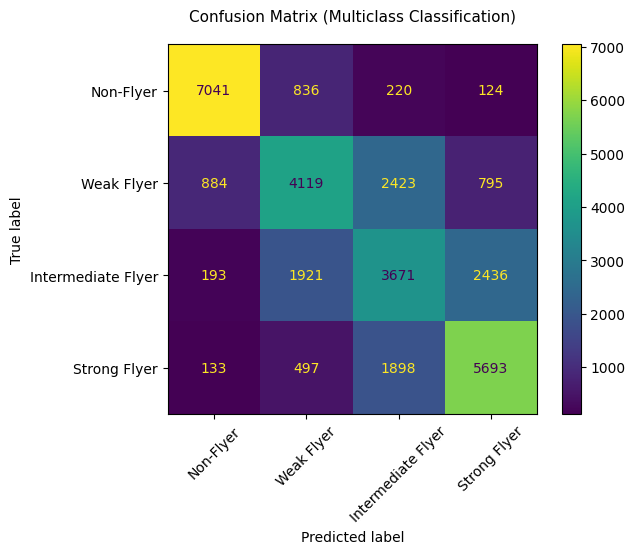

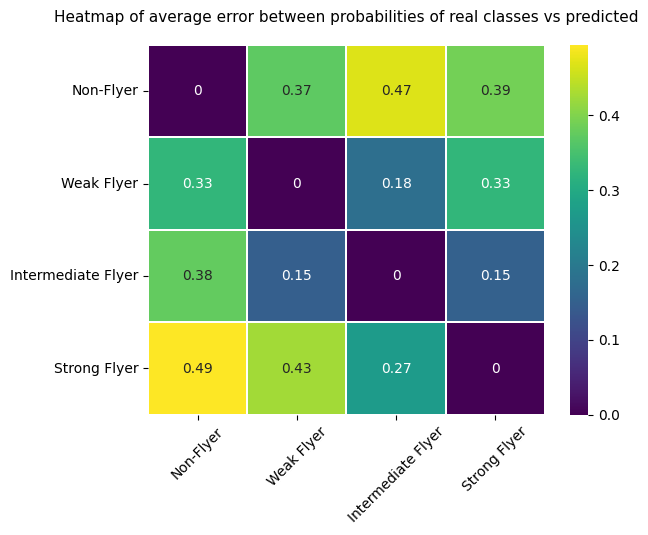

In [37]:
report.generate_report()

### Example: Defining a Classification Threshold

In the following example, a specific classification threshold is defined to adjust the decision boundary for the model's predictions. By setting a threshold, you can control the sensitivity of the model, influencing how it categorizes the output into different classes.

In [38]:
report_using_threshold = DetectabilityReport(test_targets_one_hot, 
                                             predictions, 
                                             test_data_df, 
                                             output_path = "./output/report_on_ProteomeTools_with_threshold", 
                                             history = history, 
                                             rank_by_prot = False,
                                             threshold = 0.5,                              
                                             name_of_dataset = 'ProteomeTools',
                                             name_of_model = 'Base model (new) with threshold')

Binary Accuracy: 0.93

Categorical Accuracy: 0.63

Matthews Correlation Coefficient (MCC): 0.82

True Positive Rate (Recall): 0.96

False Positive Rate (Specificity): 0.84

Precision: 0.95

F1 Score: 0.96


#### Predictions report 

In [39]:
report_using_threshold.detectability_report_table.head(5)

,Sequences,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions,Rank
0,SYLYFEEK,0.010,0.058,0.932,0.001,1.000,Strong Flyer,Strong Flyer,Flyer,Flyer,1
1,EYLQSLSYK,0.020,0.109,0.871,0.001,1.000,Strong Flyer,Strong Flyer,Flyer,Flyer,2
2,DYVIDLEK,0.009,0.057,0.933,0.002,0.999,Strong Flyer,Strong Flyer,Flyer,Flyer,3
3,SYVDLLVK,0.013,0.067,0.919,0.002,0.999,Intermediate Flyer,Strong Flyer,Flyer,Flyer,4
4,VYTQVEFK,0.012,0.074,0.913,0.001,0.999,Strong Flyer,Strong Flyer,Flyer,Flyer,5


Generating a complete PDF report using the `generate_report` function.

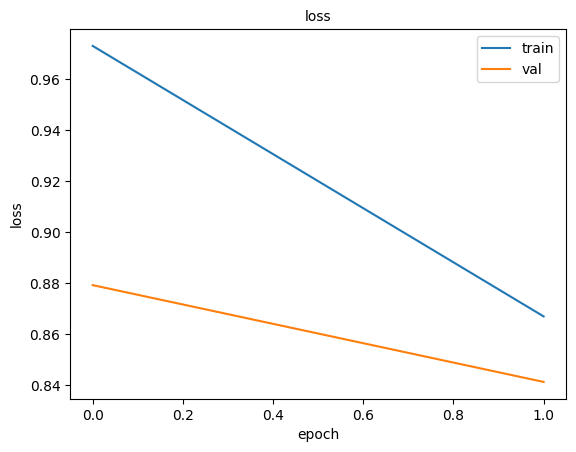

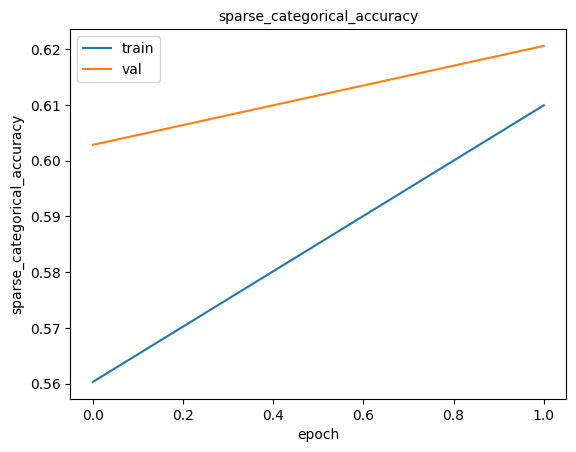

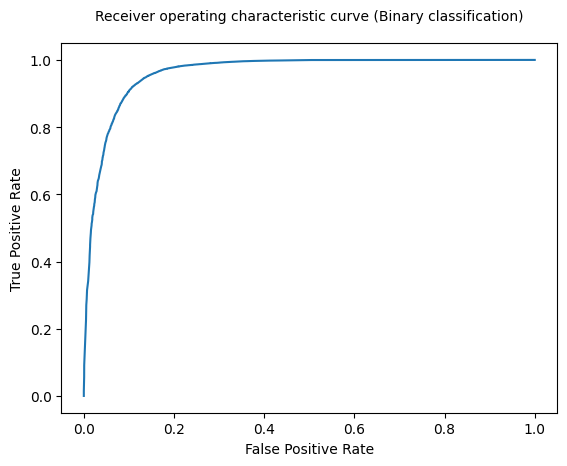

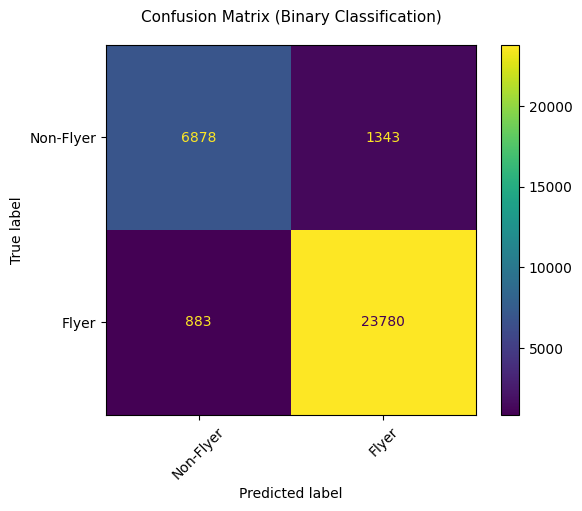

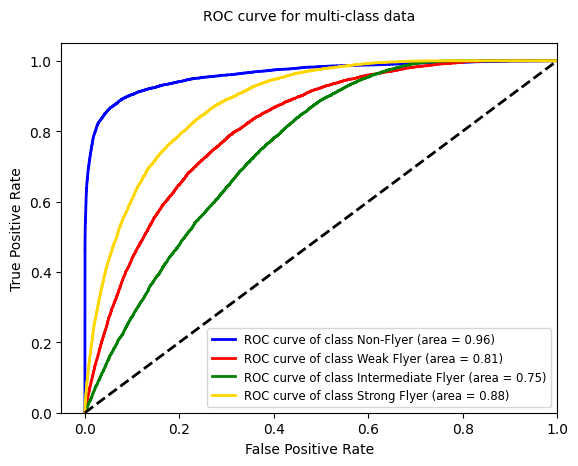

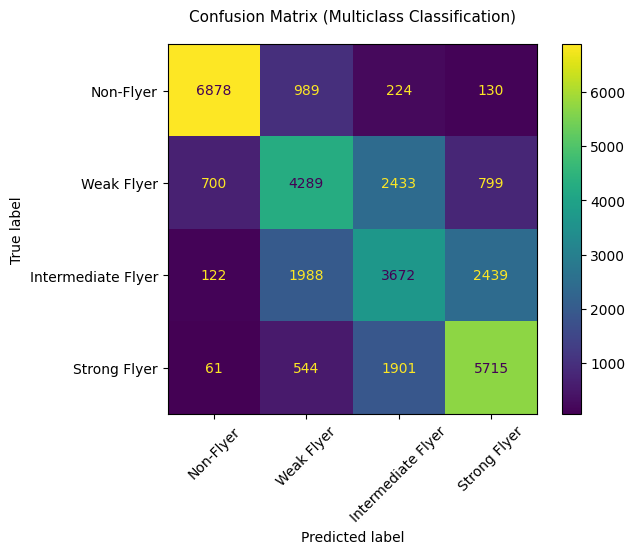

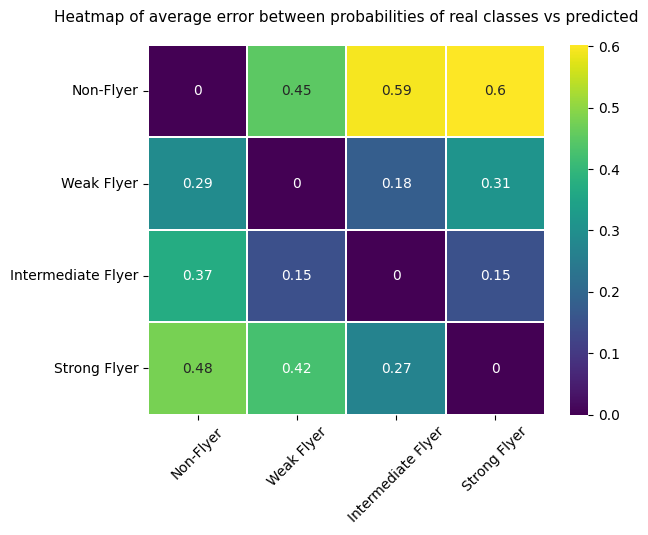

In [40]:
report_using_threshold.generate_report()

## 5. Load data for fine tuning

For fine-tuning, the process mirrors the steps used during training. Simply create a `DetectabilityDataset` object with the fine-tuning data (refer to **Section 1: Load Data for Training**).

In [42]:
max_pep_length = 40
BATCH_SIZE = 128 # FIX BATCH SIZE
            
# The Class handles all the inner details, we have to provide the column names and the alphabet for encoding
# If the data is already split with a specific logic (which is generally recommended) -> val_data_source and test_data_source are available as well

# Splitting on Proteins is not implemented -> we should have this logic outside of the Dataset class

hf_data = "Wilhelmlab/detectability-sinitcyn"
fine_tune_data = DetectabilityDataset(data_source=hf_data,
                                      data_format='hub',
                                      max_seq_len=max_pep_length,
                                      label_column="Classes",
                                      sequence_column="Sequences",
                                      dataset_columns_to_keep=['Proteins'],
                                      batch_size=BATCH_SIZE,
                                      with_termini=False,
                                      alphabet=aa_to_int_dict)

Generating train split:   0%|          | 0/167882 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/18654 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60185 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split train...


/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:262: UserWarning: The provided data is assumed to be hosted on the Hugging Face Hub since data_format is set to "hub". Validation and test data sources will be ignored.
  warnings.warn(
/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:329: UserWarning: 
                Multiple data sources or a single non-train data source provided {'train': 'HF hub dataset - Wilhelmlab/detectability-sinitcyn - train', 'val': 'HF hub dataset - Wilhelmlab/detectability-sinitcyn - val', 'test': 'HF hub dataset - Wilhelmlab/detectability-sinitcyn - test'}, please ensure that the data sources are already split into train, val and test sets
                since no splitting will happen. If not, please provide only one data_source and set the val_ratio to split the data into train and val sets."
                
  warnings.warn(
/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:3

Mapping SequenceParsingProcessor:   0%|          | 0/167882 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split val...


Mapping SequenceParsingProcessor:   0%|          | 0/18654 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split test...


Mapping SequenceParsingProcessor:   0%|          | 0/60185 [00:00<?, ? examples/s]

Applying step: SequencePTMRemovalProcessor on split train...


Mapping SequencePTMRemovalProcessor:   0%|          | 0/167882 [00:00<?, ? examples/s]

Applying step: SequencePTMRemovalProcessor on split val...


Mapping SequencePTMRemovalProcessor:   0%|          | 0/18654 [00:00<?, ? examples/s]

Applying step: SequencePTMRemovalProcessor on split test...


Mapping SequencePTMRemovalProcessor:   0%|          | 0/60185 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split train...


Mapping SequenceEncodingProcessor:   0%|          | 0/167882 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split val...


Mapping SequenceEncodingProcessor:   0%|          | 0/18654 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split test...


Mapping SequenceEncodingProcessor:   0%|          | 0/60185 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split train...


Mapping SequencePaddingProcessor:   0%|          | 0/167882 [00:00<?, ? examples/s]

Filter:   0%|          | 0/167882 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split val...


Mapping SequencePaddingProcessor:   0%|          | 0/18654 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18654 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split test...


Mapping SequencePaddingProcessor:   0%|          | 0/60185 [00:00<?, ? examples/s]

In [43]:
pd.read_csv("/Users/Omar/Desktop/Refactored_notebooks_and_data_splits/Sinitcyn/1_Sinitcyn_train_dataset.csv").shape, pd.read_csv("/Users/Omar/Desktop/Refactored_notebooks_and_data_splits/Sinitcyn/2_Sinitcyn_val_dataset.csv").shape, pd.read_csv("/Users/Omar/Desktop/Refactored_notebooks_and_data_splits/Sinitcyn/3_Sinitcyn_test_dataset.csv").shape

((167882, 3), (18654, 3), (60185, 3))

In [44]:
fine_tune_data

DatasetDict({
    train: Dataset({
        features: ['Sequences', 'Classes', 'Proteins', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 167882
    })
    val: Dataset({
        features: ['Sequences', 'Classes', 'Proteins', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 18654
    })
    test: Dataset({
        features: ['Sequences', 'Classes', 'Proteins', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 60185
    })
})

## 6. Fine tuning the model

In the next cell, we create the model and load its weights for fine-tuning. By default, the path is set to the weights of the most recently trained base model. To use different weights, update the path to point to your desired model's weights.

In [46]:
# define again if not in environment from training run
load_model_path = model_save_path #'output/weights/new_base_model/base_model_weights_detectability'

fine_tuned_model = DetectabilityModel(num_units = num_cells,  
                                      num_clases = total_num_classes)

fine_tuned_model.load_weights(load_model_path)

#### Compile the Model

Compile the model with the selected settings. You can use built-in TensorFlow options or define and pass custom settings for the optimizer, loss function, and metrics. The default configurations match those used in the original study, but you can modify these settings according to your preferences.Early stopping is also configured with the original settings, but the parameters can be adjusted based on user preferences.

In [47]:
# compile the model  with the optimizer and the metrics we want to use.
callback_FT = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                               mode = 'min', 
                                               verbose = 1, 
                                               patience = 5)


model_save_path_FT = 'output/weights/new_fine_tuned_model/fine_tuned_model_weights_detectability'

model_checkpoint_FT = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path_FT,
                                                         monitor='val_sparse_categorical_accuracy', # changed to sparse categorical accuracy (no need to one-hot encode the true labels)
                                                         mode='max',
                                                         verbose=1,
                                                         save_best_only=True, 
                                                         save_weights_only=True)

fine_tuned_model.compile(optimizer='adam',
                         loss='SparseCategoricalCrossentropy', 
                         metrics='sparse_categorical_accuracy') # changed to sparse version to spare one-hot encoding the labels

We store the result of training so that we can explore the metrics and the losses later. We specify the number of epochs for training and pass the training and validation data as previously described.

In [48]:
history_fine_tuned = fine_tuned_model.fit(fine_tune_data.tensor_train_data,
                                          validation_data=fine_tune_data.tensor_val_data,
                                          epochs=50, 
                                          callbacks=[callback_FT, model_checkpoint_FT])

Epoch 1/2


/Users/Omar/miniconda3/envs/dlx/lib/python3.11/site-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


1312/1312 [==============================] - ETA: 0s - loss: 1.2516 - sparse_categorical_accuracy: 0.3901
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.39471, saving model to output/weights/new_fine_tuned_model/fine_tuned_model_weights_detectability
1312/1312 [==============================] - 342s 258ms/step - loss: 1.2516 - sparse_categorical_accuracy: 0.3901 - val_loss: 1.2412 - val_sparse_categorical_accuracy: 0.3947
Epoch 2/2
1312/1312 [==============================] - ETA: 0s - loss: 1.2364 - sparse_categorical_accuracy: 0.4003
Epoch 2: val_sparse_categorical_accuracy improved from 0.39471 to 0.39954, saving model to output/weights/new_fine_tuned_model/fine_tuned_model_weights_detectability
1312/1312 [==============================] - 332s 253ms/step - loss: 1.2364 - sparse_categorical_accuracy: 0.4003 - val_loss: 1.2340 - val_sparse_categorical_accuracy: 0.3995


## 7. Testing and Reporting (Fine-Tuned Model)

In the following cell, we load the best model weights obtained from fine-tuning. By default, the path points to the most recently fine-tuned model from the previous cell. Update the path if you wish to load different weights.

In [49]:
## Loading best model's weights 

model_save_path_FT = 'output/weights/new_fine_tuned_model/fine_tuned_model_weights_detectability'

fine_tuned_model.load_weights(model_save_path_FT)

Generating predictions on the test data using the fine-tuned model with `model.predict`.

In [50]:
predictions_FT = fine_tuned_model.predict(fine_tune_data.tensor_test_data)

471/471 [==============================] - 76s 160ms/step


In [51]:
predictions_FT.shape

(60185, 4)

To generate reports and calculate evaluation metrics against predictions, we obtain the targets and the data for the specific dataset split. This can be achieved using the DetectabilityDataset class directly.

In [52]:
# access val dataset and get the Classes column
test_targets_FT = fine_tune_data["test"]["Classes"]


# if needed, the decoded version of the classes can be retrieved by looking up the class names
test_targets_decoded_FT = [CLASSES_LABELS[x] for x in test_targets_FT]


test_targets_FT[0:5], test_targets_decoded_FT[0:5]

([1, 3, 3, 0, 2],
 ['Weak Flyer',
  'Strong Flyer',
  'Strong Flyer',
  'Non-Flyer',
  'Intermediate Flyer'])

In [53]:
# The dataframe needed for the report

test_data_df_FT = pd.DataFrame(
    {
        "Sequences": fine_tune_data["test"]["_parsed_sequence"], # get the raw parsed sequences
        "Classes": test_targets_FT, # get the test targets from above
        "Proteins": fine_tune_data["test"]["Proteins"] # get the Proteins column from the dataset object
    }
)

test_data_df_FT.Sequences = test_data_df_FT.Sequences.apply(lambda x: "".join(x)) # join the sequences since they are a list of string amino acids.
test_data_df_FT.head(5)

,Sequences,Classes,Proteins
0,TNQLEAINAALLGEDCFILMPTGGGK,1,P54132
1,QAYTSAPMVDNELLR,3,Q5T200
2,LTVENIGYQMLMK,3,Q8IWZ8
3,NFLFRPTSANMLQHPFVR,0,Q7Z2Y5
4,ICLDNDER,2,Q03188


Creating a report object with the test targets, predictions, and history to generate metrics and plots for the fine-tuned model. For more details, refer to Section 4: Testing and Reporting, which provides a detailed description of the same process for the initial or base model.

In [54]:
# Since the detectabiliy report expects the true labels in one-hot encoded format, we expand them here. Otherwise, the reporting class can be updated.

num_classes = np.max(test_targets_FT) + 1
test_targets_FT_one_hot = np.eye(num_classes)[test_targets_FT] # THIS CAN BE CHANGED 
test_targets_FT_one_hot.shape, len(test_targets_FT)

((60185, 4), 60185)

In [55]:
report_FT = DetectabilityReport(test_targets_FT_one_hot, 
                                predictions_FT, 
                                test_data_df_FT, 
                                output_path = './output/report_on_Sinitcyn (Fine-tuned model)', 
                                history = history_fine_tuned, 
                                rank_by_prot = True,
                                threshold = None,                              
                                name_of_dataset = 'Sinitcyn test dataset',
                                name_of_model = 'Fine tuned model (new)')

Binary Accuracy: 0.78

Categorical Accuracy: 0.45

Matthews Correlation Coefficient (MCC): 0.48

True Positive Rate (Recall): 0.86

False Positive Rate (Specificity): 0.61

Precision: 0.82

F1 Score: 0.84


#### Predictions report (Fine-tuned model)

In [56]:
results_df_FT = report_FT.detectability_report_table
results_df_FT

,Sequences,Proteins,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions,Rank
0,ILFLVAAATGAHSQVQLVQSGSELK,A0A0J9YVY3,0.275,0.289,0.196,0.241,0.760,Intermediate Flyer,Intermediate Flyer,Flyer,Flyer,1
1,QAPGQGLEWMGWINTNTGNPTYAQGFTGR,A0A0J9YVY3,0.293,0.256,0.162,0.288,0.711,Non-Flyer,Weak Flyer,Non-Flyer,Flyer,2
2,ASGYTFTSYAMNWVR,A0A0J9YVY3,0.319,0.254,0.137,0.289,0.710,Non-Flyer,Weak Flyer,Non-Flyer,Flyer,3
3,FVFSLDTSVSTAYLQICSLK,A0A0J9YVY3,0.223,0.092,0.021,0.663,0.336,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,4
4,KPGASVK,A0A0J9YVY3,0.018,0.002,0.000,0.980,0.020,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,5
...,...,...,...,...,...,...,...,...,...,...,...,...
60180,QLWMPFSVFDSLNLEEIYNSVQPDPESVVLGTDGGR,Q9Y6Y8,0.108,0.034,0.006,0.852,0.148,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,35
60181,AVAATSTK,Q9Y6Y8,0.112,0.027,0.004,0.856,0.143,Weak Flyer,Non-Flyer,Flyer,Non-Flyer,36
60182,IDYVLQEKPIESFNEYLFALQSHLCYWESEDTALLLLK,Q9Y6Y8,0.094,0.026,0.004,0.876,0.124,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,37
60183,GQEQSAQK,Q9Y6Y8,0.035,0.003,0.000,0.961,0.038,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,38


Generating a complete PDF report using the `generate_report` function.

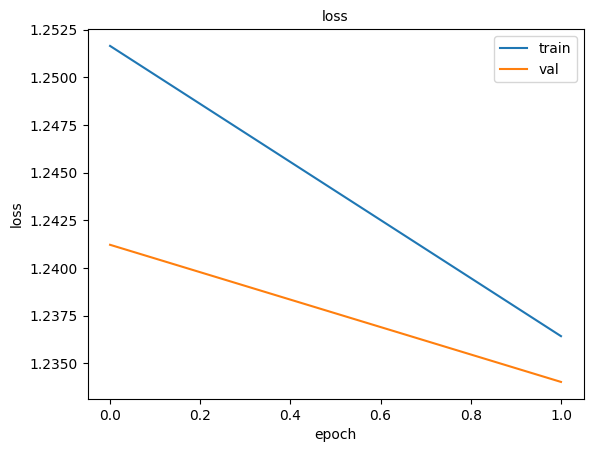

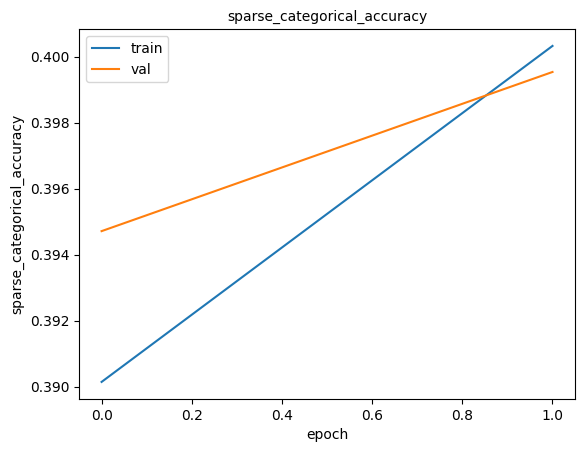

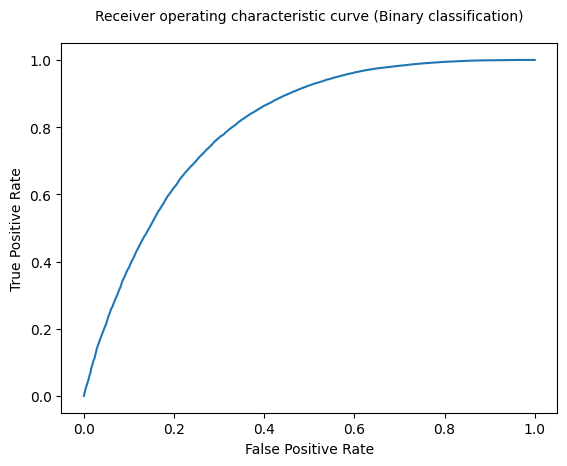

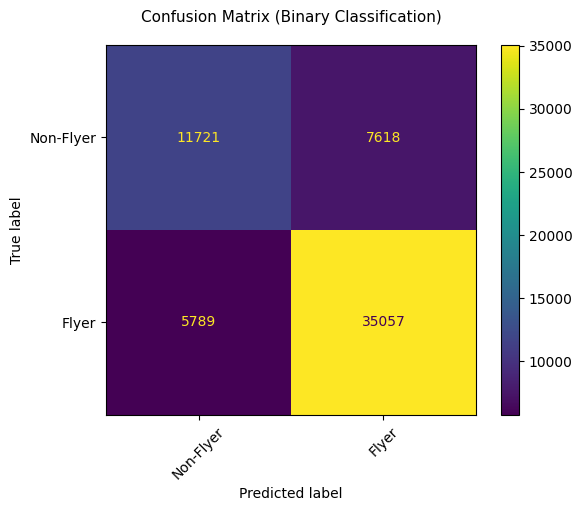

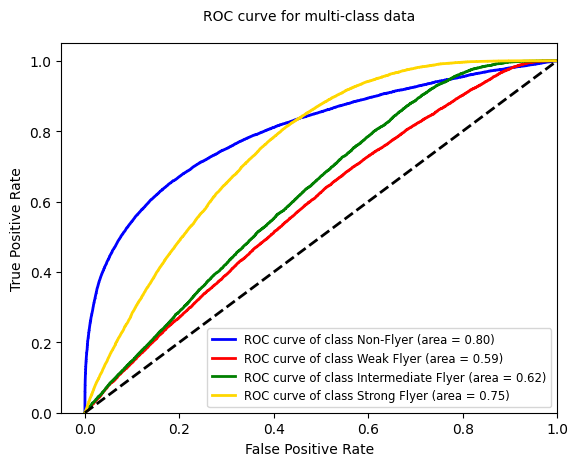

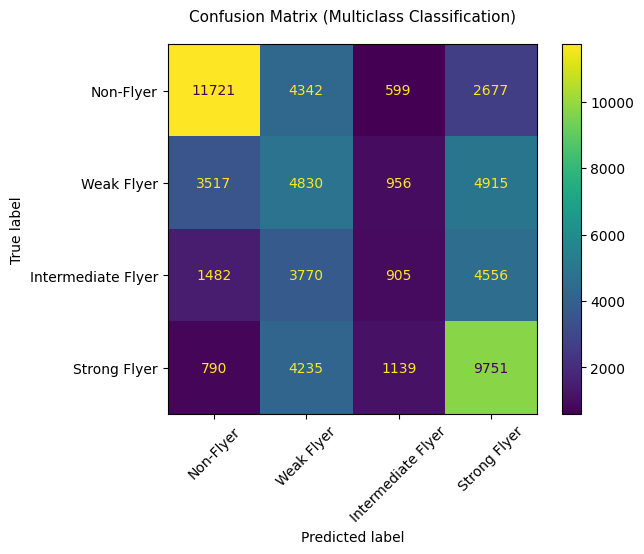

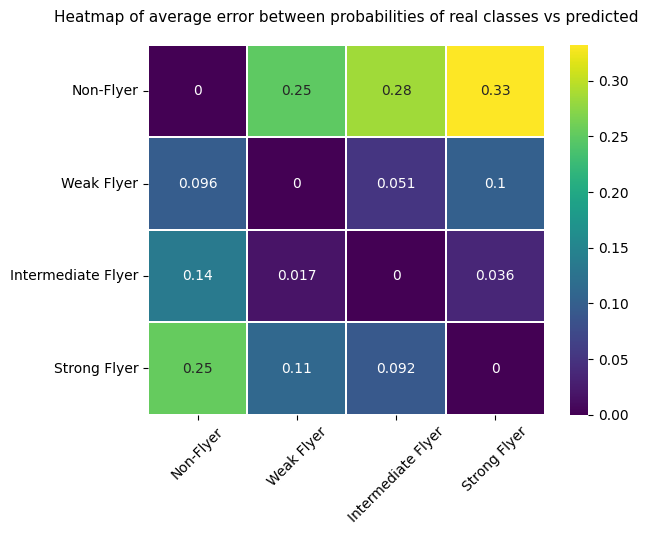

In [57]:
report_FT.generate_report()

#### Generating the Evaluation Plots for the Fine-Tuned Model

##### Training and Validation Metrics

These plots show the training and validation metrics over epochs. The first plot displays the loss, and the second shows the categorical accuracy.

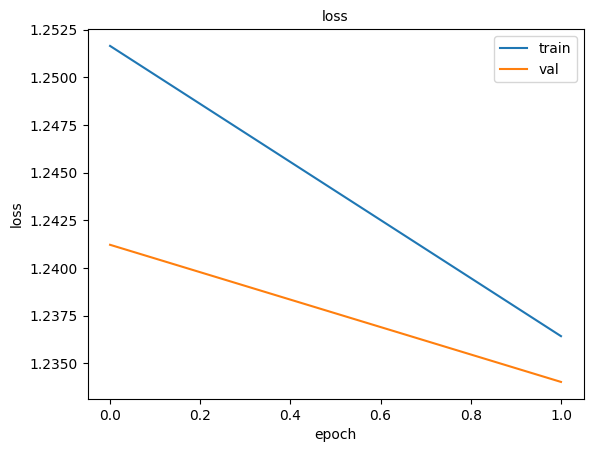

In [58]:
report_FT.plot_keras_metric("loss")

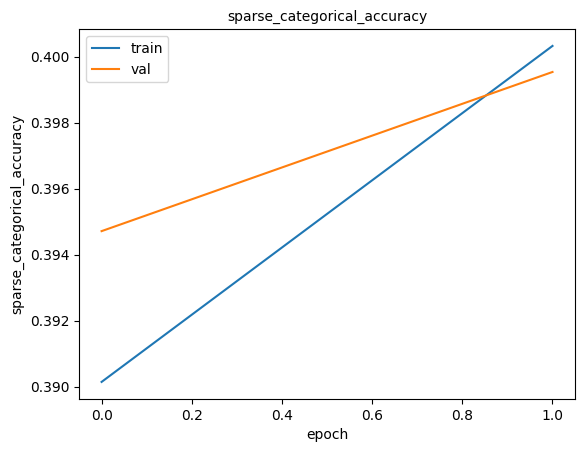

In [59]:
report_FT.plot_keras_metric("sparse_categorical_accuracy")

##### ROC curve (Binary)

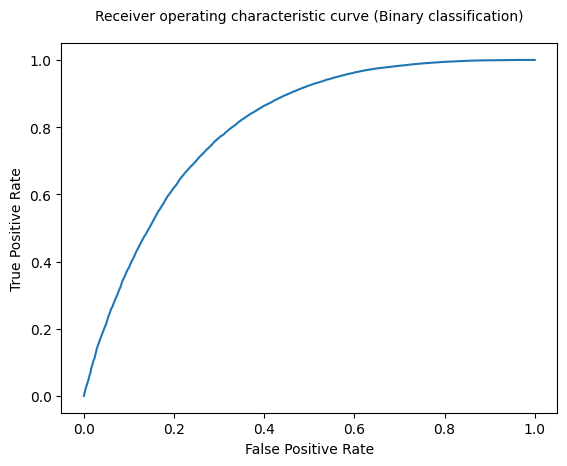

In [60]:
report_FT.plot_roc_curve_binary()

##### Confusion matrix (Binary)

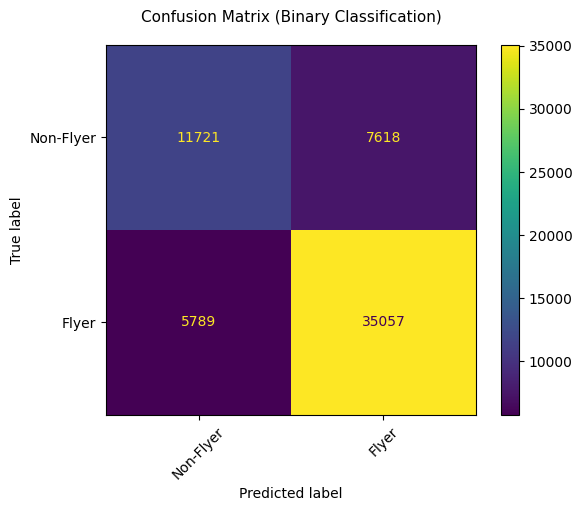

In [61]:
report_FT.plot_confusion_matrix_binary()

##### ROC curve (Multi-class)

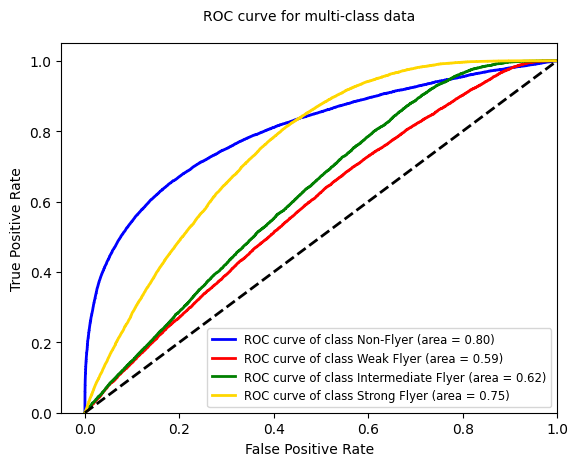

In [62]:
report_FT.plot_roc_curve()

##### Confusion matrix (Multi-class)

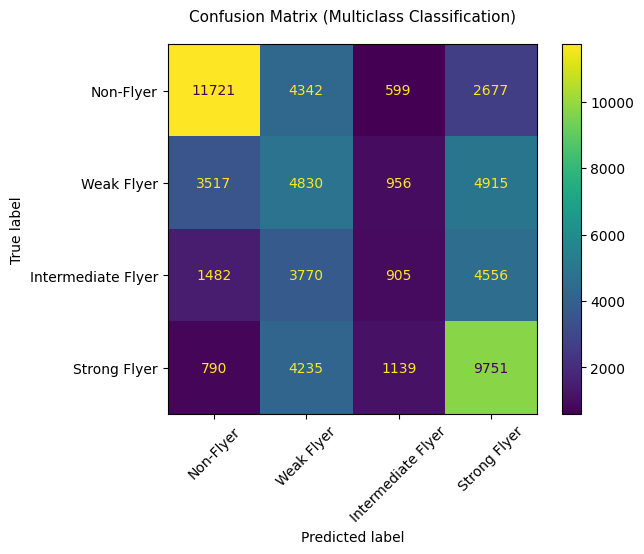

In [63]:
report_FT.plot_confusion_matrix_multiclass()

#### Heatmap of Average Error Between Actual and Predicted Classes

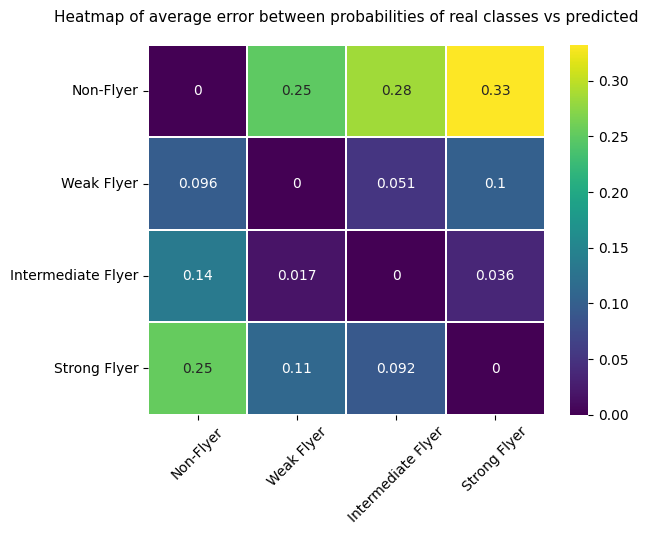

In [64]:
report_FT.plot_heatmap_prediction_prob_error()